In [2]:
# import librairies and functions needed for project

# utilities
import os
os.environ["OMP_NUM_THREADS"] = '1' # needed to avoid memory leak warning with K-Means in Windows environment
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning) # ignore all future warnings

# data
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None) # maximise dataframe display

# modelisation
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import rand_score
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score, fowlkes_mallows_score

# visualisation
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})

# Définir la couleur bleue
col = "blue"

# import user-defined functions
from functions import *

<span style="font-size:24px; font-weight:bold;">1 - K-means </span>

In [3]:
# Import data & split file
data = pd.read_csv('billets_final.csv', encoding='latin_1')

# include all variables
x = data[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']].values

# include only variables that are statistically significant for Logistic Regession (p-value < 5%)
# x = data[['height_right', 'margin_low', 'margin_up', 'length']].values

# banknotes = data.index
dimensions = data.columns.drop('is_genuine')

# create train & test data sets
y = data['is_genuine']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True, stratify=None)

print(f"Nous avons x_train de forme {x_train.shape} et y_train de forme {y_train.shape}")
unique_yt, counts_yt = np.unique(y_train, return_counts=True)
print("True/False mix in training set:\n", np.asarray((unique_yt, counts_yt)).T)
print(f"Nous avons x_test de forme {x_test.shape} et y_test de forme {y_test.shape}")
unique_ytt, counts_ytt = np.unique(y_test, return_counts=True)
print("True/False mix in testing set:\n", np.asarray((unique_ytt, counts_ytt)).T)

Nous avons x_train de forme (1200, 6) et y_train de forme (1200,)
True/False mix in training set:
 [[  0 390]
 [  1 810]]
Nous avons x_test de forme (300, 6) et y_test de forme (300,)
True/False mix in testing set:
 [[  0 110]
 [  1 190]]


In [4]:
# export training & testing sets to re-use for training logistic regression model
pd.DataFrame(x_train, columns=dimensions).to_csv('x_train.csv', index=None, encoding='latin_1')
y_train.to_csv('y_train.csv', index=False, encoding='latin_1')
pd.DataFrame(x_test, columns=dimensions).to_csv('x_test.csv', index=None, encoding='latin_1')
y_test.to_csv('y_test.csv', index=False, encoding='latin_1')

# center & reduce data
std_scaler = StandardScaler()
x_train_scaled = std_scaler.fit_transform(x_train)

<span style="font-size:14px; font-weight:bold;">1.1) Evaluation de clustering</span>

<span style="font-size:14px; font-weight:bold;">a. Méthode du coude</span>

C:\Users\jemko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1418: RuntimeWarning:

algorithm='elkan' doesn't make sense for a single cluster. Using 'lloyd' instead.



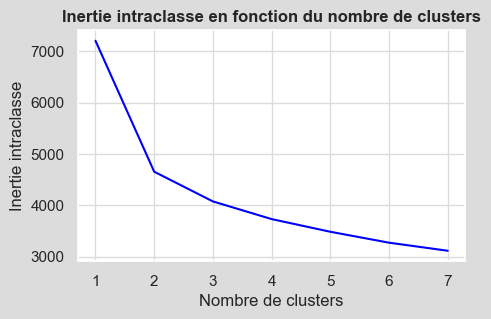

In [70]:
# test for number of clusters between 1 and number of columns in data (=11)
k_list = range(1, data.shape[1] + 1)

# create data for within-cluster sum of squares for K-means clusters between 1 and 11
wcss = []

for i in k_list:
    kmeans_wcss = KMeans(n_clusters=i, init='k-means++', copy_x=True, algorithm='elkan', n_init=30, max_iter=300,
                         verbose=0, random_state=42, tol=0.00001)
    kmeans_wcss.fit(x_train_scaled)
    wcss.append(kmeans_wcss.inertia_)

# plot wcss curve
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.set_ylabel("Inertie intraclasse")
ax.set_xlabel("Nombre de clusters")
ax.set_title("Inertie intraclasse en fonction du nombre de clusters", fontsize=12, fontweight='bold')
ax = plt.plot(k_list, wcss, color=col)
plt.xticks(np.arange(min(k_list), max(k_list) + 1, 1.0))
plt.grid(axis='both', color='gainsboro')
plt.savefig("kmeans_coude.png", bbox_inches='tight')
plt.show()

<span style="font-size:14px; font-weight:bold;">b. Silhouette score</span>

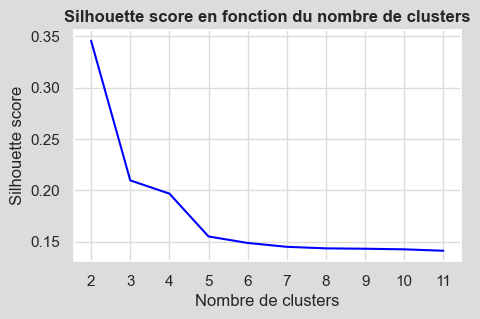

In [77]:
# calculate score for number of K-means clusters between 2 and 11
k_list = range(2, 12)  # Start from 2 and go up to 11
silhouette = []

for j in k_list:
    kmeans_silh = KMeans(n_clusters=j, init='k-means++', copy_x=True, algorithm='elkan', n_init=30, max_iter=300,
                         verbose=0, random_state=42, tol=0.00001)
    kmeans_silh.fit(x_train_scaled)
    silh = silhouette_score(x_train_scaled, kmeans_silh.labels_)
    silhouette.append(silh)
    
# plot silhouette score curve
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.set_ylabel("Silhouette score")
ax.set_xlabel("Nombre de clusters")
ax.set_title("Silhouette score en fonction du nombre de clusters", fontsize=12, fontweight='bold')
ax = plt.plot(k_list, silhouette, color=col)
plt.xticks(np.arange(min(k_list), max(k_list) + 1, 1.0))
plt.grid(axis='both', color='gainsboro')
plt.savefig("silhouette.png", bbox_inches='tight')
plt.show()

<span style="font-size:14px; font-weight:bold;">c. Davies-Bouldin index</span>

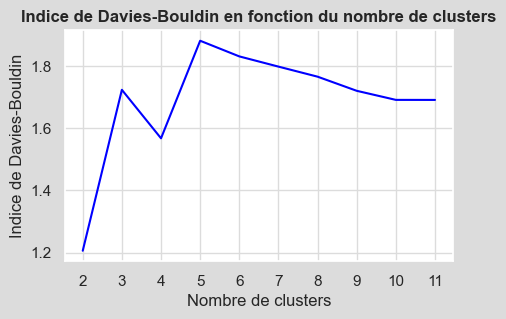

In [80]:
# calculate score for number of K-means clusters between 2 and 11
k_list = range(2, 12)  # Start from 2 and go up to 11
dav_bould = []

for h in k_list:
    kmeans_db = KMeans(n_clusters=h, init='k-means++', copy_x=True, algorithm='elkan', n_init=30, max_iter=300,
                       verbose=0, random_state=42, tol=0.00001)
    kmeans_db.fit(x_train_scaled)
    # Calculate Davies-Bouldin score for clusters of size 2 or more
    d_b = davies_bouldin_score(x_train_scaled, kmeans_db.labels_)
    dav_bould.append(d_b)

# plot Davies-Bouldin score curve
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.set_ylabel("Indice de Davies-Bouldin")
ax.set_xlabel("Nombre de clusters")
ax.set_title("Indice de Davies-Bouldin en fonction du nombre de clusters", fontsize=12, fontweight='bold')
ax = plt.plot(k_list, dav_bould, color=col)
plt.xticks(np.arange(min(k_list), max(k_list) + 1, 1.0))
plt.grid(axis='both', color='gainsboro')
plt.savefig("davies_bouldin.png", bbox_inches='tight')
plt.show()

Les illustrations ci-dessus confirment 2, 3 et 4 comme les nombres de clusters les plus probablement interessants pour notre analyse. 

<span style="font-size:14px; font-weight:bold;">1.2) Clustering & analyse des centroides</span>

<span style="font-size:14px; font-weight:bold;">a) 2 clusters</span>

In [81]:
clusters = pd.DataFrame(y_train)
clusters[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
          'length']] = x_train_scaled
clusters['is_genuine'].value_counts()

is_genuine
True     810
False    390
Name: count, dtype: int64

In [9]:
# run K-means
kmeans_2 = KMeans(n_clusters=2, init='k-means++', copy_x=True, algorithm='elkan', n_init=30, max_iter=300, verbose=0,
                  random_state=42, tol=0.00001)
kmeans_2.fit(x_train_scaled)
labels_2 = kmeans_2.labels_

# add cluster number to each country in clusters dataframe
clusters['cluster_km_2'] = (kmeans_2.labels_ + 1)

In [10]:
inertie_2 = round(kmeans_2.inertia_, 2)
print(f"Inertie: {inertie_2} - Nb iterations: {kmeans_2.n_iter_} ")

Inertie: 4655.36 - Nb iterations: 5 


In [11]:
clusters.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
382         True  1.050853     1.958416     -0.367712   -0.597290  -0.306118   
538         True -0.185700     1.559864     -1.317963   -0.597290  -1.428167   
1493       False -1.064303     0.995247      2.115204    0.618607   0.859087   
1112       False  0.334954     0.829184      1.195606    1.728113   0.513841   
324         True  0.465117     1.294162     -0.980777   -0.445303  -1.126077   

        length  cluster_km_2  
382   0.648529             1  
538   0.921625             1  
1493 -0.603164             2  
1112 -1.229011             2  
324   0.716803             1

In [12]:
# create centroids dataframe
centroids_2 = kmeans_2.cluster_centers_
centroids_km_2 = pd.DataFrame(centroids_2)
centroids_km_2.columns = dimensions
centroids_km_2

diagonal  height_left  height_right  margin_low  margin_up    length
0  0.089125    -0.262568     -0.341261   -0.537137  -0.415777  0.582539
1 -0.190118     0.560100      0.727963    1.145800   0.886919 -1.242648

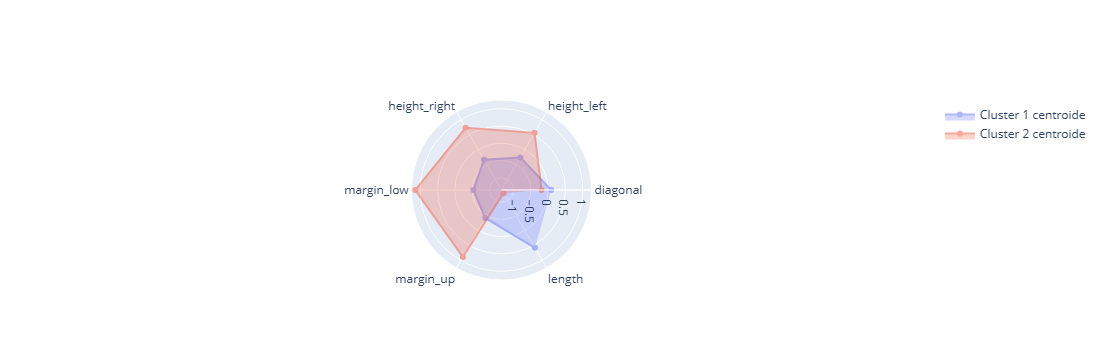

In [13]:
# plot polar chart centroids
categories = centroids_km_2.columns
fig = go.Figure()
fig.add_trace(go.Scatterpolar(r=centroids_km_2.iloc[0], theta=categories, fill='toself', name='Cluster 1 centroide'))
fig.add_trace(go.Scatterpolar(r=centroids_km_2.iloc[1], theta=categories, fill='toself', name='Cluster 2 centroide'))
fig.update_traces(opacity=0.5, selector=dict(type='scatterpolar'))
fig.show()

<span style="font-size:14px; font-weight:bold;">b) 3 clusters</span>

In [82]:
# run K-means
kmeans_3 = KMeans(n_clusters=3, init='k-means++', copy_x=True, algorithm='elkan', n_init=30, max_iter=300, verbose=0,
                  random_state=42, tol=0.00001)
kmeans_3.fit(x_train_scaled)
labels_3 = kmeans_3.labels_

# add cluster number to each country in clusters dataframe
clusters['cluster_km_3'] = (kmeans_3.labels_ + 1)

In [15]:
inertie_3 = round(kmeans_3.inertia_, 2)
print(f"Inertie: {inertie_3} - Nb iterations: {kmeans_3.n_iter_} ")

Inertie: 4078.21 - Nb iterations: 21 


In [16]:
clusters.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
382         True  1.050853     1.958416     -0.367712   -0.597290  -0.306118   
538         True -0.185700     1.559864     -1.317963   -0.597290  -1.428167   
1493       False -1.064303     0.995247      2.115204    0.618607   0.859087   
1112       False  0.334954     0.829184      1.195606    1.728113   0.513841   
324         True  0.465117     1.294162     -0.980777   -0.445303  -1.126077   

        length  cluster_km_2  cluster_km_3  
382   0.648529             1             1  
538   0.921625             1             1  
1493 -0.603164             2             2  
1112 -1.229011             2             2  
324   0.716803             1             1

In [17]:
# create centroids dataframe
centroids_3 = kmeans_3.cluster_centers_
centroids_km_3 = pd.DataFrame(centroids_3)
centroids_km_3.columns = dimensions
centroids_km_3

diagonal  height_left  height_right  margin_low  margin_up    length
0  0.470384     0.464245     -0.195861   -0.560371  -0.345104  0.585752
1 -0.190838     0.557189      0.728224    1.157841   0.888955 -1.250511
2 -0.301036    -0.994899     -0.481869   -0.512281  -0.480123  0.573136

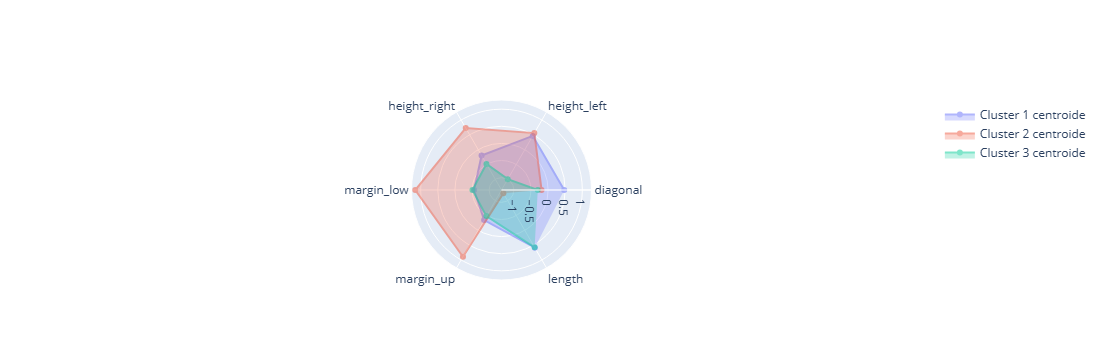

In [18]:
# plot polar chart centroids
categories = centroids_km_3.columns
fig = go.Figure()
fig.add_trace(go.Scatterpolar(r=centroids_km_3.iloc[0], theta=categories, fill='toself', name='Cluster 1 centroide'))
fig.add_trace(go.Scatterpolar(r=centroids_km_3.iloc[1], theta=categories, fill='toself', name='Cluster 2 centroide'))
fig.add_trace(go.Scatterpolar(r=centroids_km_3.iloc[2], theta=categories, fill='toself', name='Cluster 3 centroide'))
fig.update_traces(opacity=0.5, selector=dict(type='scatterpolar'))
fig.show()

<span style="font-size:14px; font-weight:bold;">c) 4 clusters</span>

In [19]:
# run K-means
kmeans_4 = KMeans(n_clusters=4, init='k-means++', copy_x=True, algorithm='elkan', n_init=30, max_iter=300, verbose=0,
                  random_state=42, tol=0.00001)
kmeans_4.fit(x_train_scaled)
labels_4 = kmeans_4.labels_

# add cluster number to each country in clusters dataframe
clusters['cluster_km_4'] = (kmeans_4.labels_ + 1)

In [20]:
inertie_4 = round(kmeans_4.inertia_, 2)
print(f"Inertie: {inertie_4} - Nb iterations: {kmeans_4.n_iter_} ")

Inertie: 3734.78 - Nb iterations: 20 


In [21]:
clusters.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
382         True  1.050853     1.958416     -0.367712   -0.597290  -0.306118   
538         True -0.185700     1.559864     -1.317963   -0.597290  -1.428167   
1493       False -1.064303     0.995247      2.115204    0.618607   0.859087   
1112       False  0.334954     0.829184      1.195606    1.728113   0.513841   
324         True  0.465117     1.294162     -0.980777   -0.445303  -1.126077   

        length  cluster_km_2  cluster_km_3  cluster_km_4  
382   0.648529             1             1             3  
538   0.921625             1             1             4  
1493 -0.603164             2             2             2  
1112 -1.229011             2             2             2  
324   0.716803             1             1             3

In [22]:
# create centroids dataframe
centroids_4 = kmeans_4.cluster_centers_
centroids_km_4 = pd.DataFrame(centroids_4)
centroids_km_4.columns = dimensions
centroids_km_4

diagonal  height_left  height_right  margin_low  margin_up    length
0 -0.281984    -1.094527     -0.686273   -0.524047  -0.556722  0.575357
1 -0.180350     0.553187      0.729444    1.183695   0.905849 -1.266031
2  1.021271     0.059468     -0.079790   -0.529603  -0.312283  0.564183
3 -0.773340     0.596694     -0.142373   -0.538705  -0.312013  0.556664

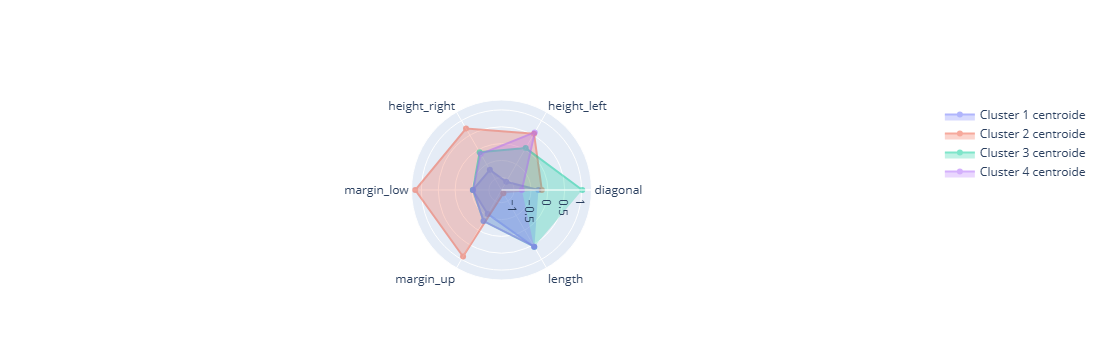

In [23]:
# plot polar chart centroids
categories = centroids_km_4.columns
fig = go.Figure()
fig.add_trace(go.Scatterpolar(r=centroids_km_4.iloc[0], theta=categories, fill='toself', name='Cluster 1 centroide'))
fig.add_trace(go.Scatterpolar(r=centroids_km_4.iloc[1], theta=categories, fill='toself', name='Cluster 2 centroide'))
fig.add_trace(go.Scatterpolar(r=centroids_km_4.iloc[2], theta=categories, fill='toself', name='Cluster 3 centroide'))
fig.add_trace(go.Scatterpolar(r=centroids_km_4.iloc[3], theta=categories, fill='toself', name='Cluster 4 centroide'))
fig.update_traces(opacity=0.5, selector=dict(type='scatterpolar'))
fig.show()

# 2 - Analyse en Composantes Principales

In [24]:
# initialise PCA
components = data.shape[1] - 1
pca = PCA(n_components=components)
pca.fit(x_train_scaled)

PCA(n_components=6)

## 2.1 - Eboulis des valeurs propres

In [25]:
# create data
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round()
a_list = range(1, components+1)
list(a_list)

[1, 2, 3, 4, 5, 6]

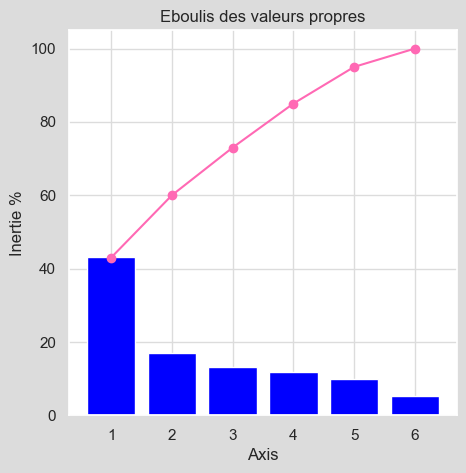

In [26]:
# plot data
plt.figure(figsize=(5, 5))
plt.bar(a_list, scree, color=col)
plt.plot(a_list, scree_cum, color='hotpink', marker='o')
plt.xlabel("Axis")
plt.ylabel("Inertie %")
plt.title("Eboulis des valeurs propres")
plt.grid(axis='both', color='gainsboro')
plt.savefig("eboulis.png", bbox_inches='tight')
plt.show(block=False)

## 2.2 - Analyse des composantes

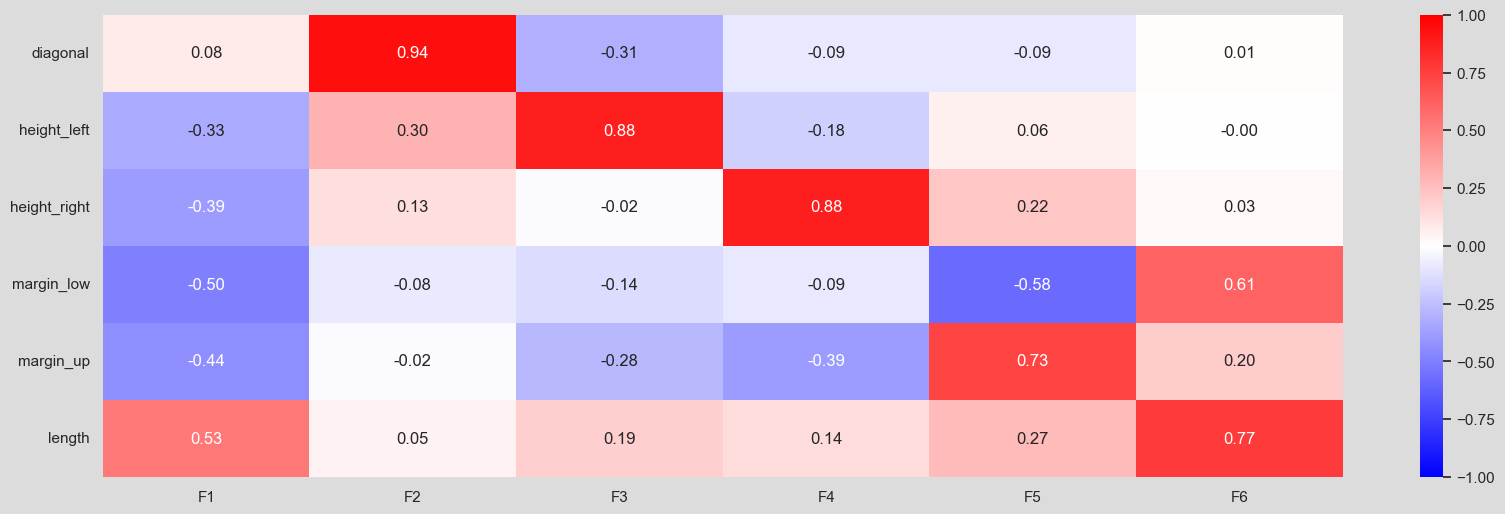

In [27]:
# create components dataframe
acp_components = pd.DataFrame(pca.components_)
acp_components.columns = dimensions
acp_components.index = [f"F{i}" for i in a_list]

# plot heatmap
fig, ax = plt.subplots(figsize=(20, 6))
acp_heatmap = sns.heatmap(acp_components.T.round(2), vmin=-1, vmax=1, annot=True, cmap="bwr", fmt="0.2f")
plt.savefig("acp_heatmap.png", bbox_inches='tight', pad_inches=0.5)

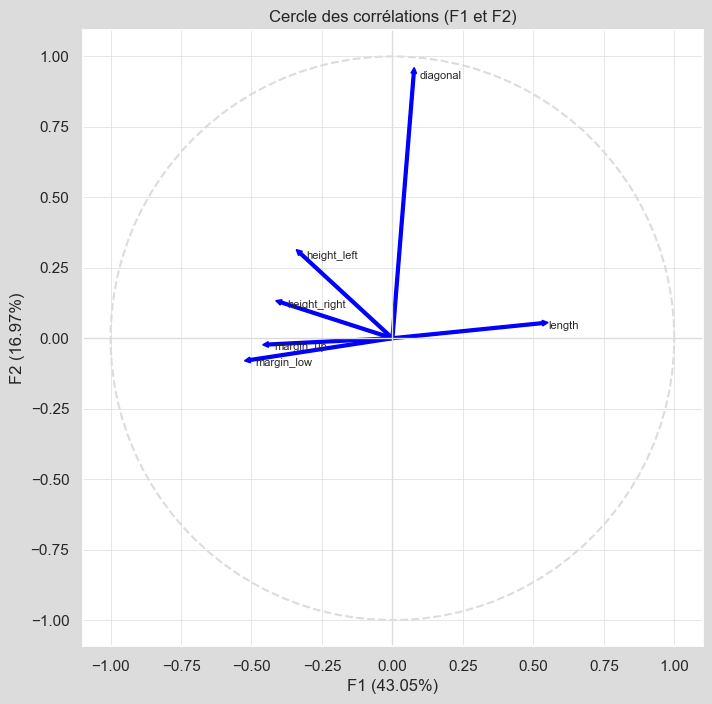

In [28]:
# draw correlation circle for axes 1 and 2
x_y = (0, 1)
correlation_graph(pca, x_y, dimensions, col=col)

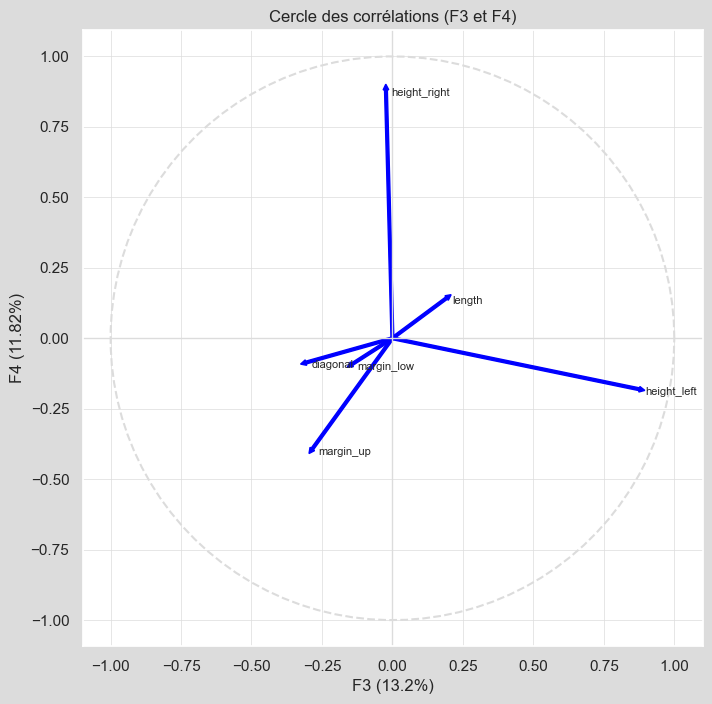

In [29]:
# draw correlation circle for axes 3 and 4
x_y = (2, 3)
correlation_graph(pca, x_y, dimensions, col=col)

## 2.3 -  Projection des clusters & centroides du K-means a 2 clusters sur le premier plan factoriel

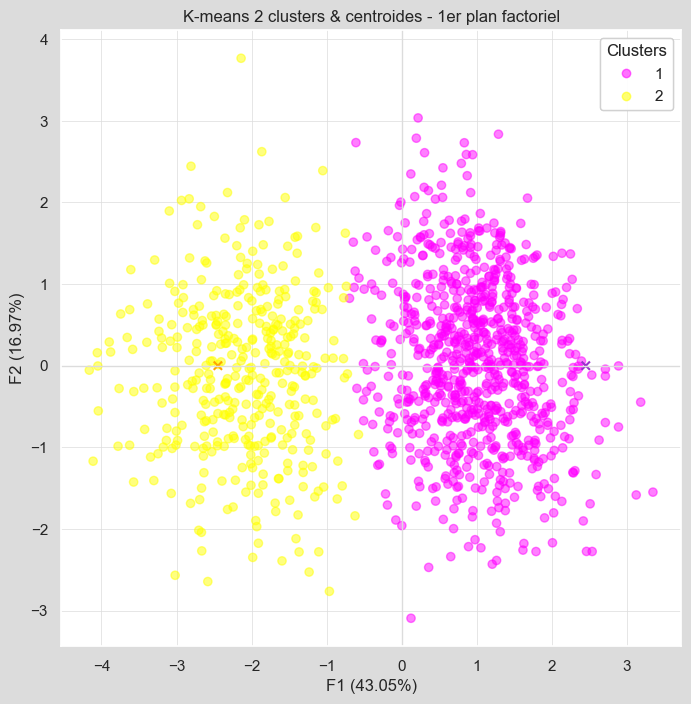

In [30]:
# plot clusters in 1st factorial plane
pca_kmeans = PCA(n_components=2, random_state=42)
pca_kmeans.fit(x_train_scaled)

x_proj = pca_kmeans.transform(x_train_scaled)
x_proj = pd.DataFrame(x_proj, columns=["PC1", "PC2"])

# use initialised scaler
centroids_2_scaled = std_scaler.fit_transform(centroids_2)

# use initialised acp
centroids_2_proj = pca_kmeans.fit_transform(centroids_2_scaled)

# create dataframe
centroids_2_proj = pd.DataFrame(centroids_2_proj,
                                columns=["F1", "F2"],
                                index=["cluster_0", "cluster_1"])

# plot results
fig, ax = plt.subplots(1, 1)
scatter = ax.scatter(x_proj.iloc[:, 0], x_proj.iloc[:, 1], c=clusters['cluster_km_2'], cmap='spring', alpha=0.5)
ax.scatter(centroids_2_proj.iloc[:, 0], centroids_2_proj.iloc[:, 1], marker="x",
           c=['darkorchid', 'orange'])

ax.set_xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0], 2)))
ax.set_ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1], 2)))

# plot thicker abscissa and ordinate lines
plt.axvline(x=0, c='gainsboro', lw=1, linestyle='solid')
plt.axhline(y=0, c='gainsboro', lw=1, linestyle='solid')

# produce a legend with the unique colors from the scatter
legend_1 = ax.legend(*scatter.legend_elements(),
                     loc="upper right", title="Clusters")
ax.add_artist(legend_1)

ax.set_title("K-means 2 clusters & centroides - 1er plan factoriel")
plt.grid(axis='both', color='gainsboro', lw=0.5)
plt.savefig("Kmeans 2 clusters & centroides - 1er plan factoriel.png", bbox_inches='tight')
plt.show()

## 2.4 -  Projection des clusters & centroides du K-means a 3 clusters sur le premier plan factoriel

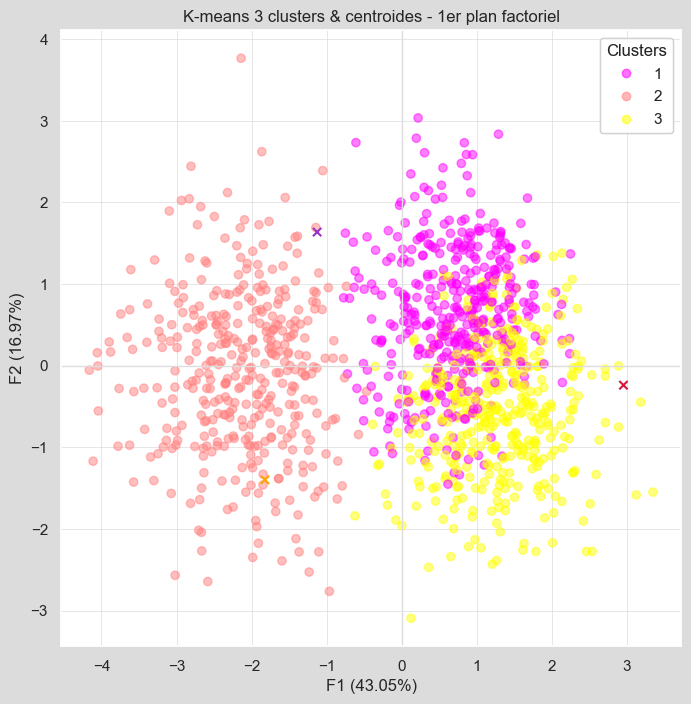

In [31]:
# use initialised scaler
centroids_3_scaled = std_scaler.fit_transform(centroids_3)

# use initialised acp
centroids_3_proj = pca_kmeans.fit_transform(centroids_3_scaled)

# create dataframe
centroids_3_proj = pd.DataFrame(centroids_3_proj,
                                columns=["F1", "F2"],
                                index=["cluster_0", "cluster_1", "cluster_2"])

# plot results
fig, ax = plt.subplots(1, 1)
scatter = ax.scatter(x_proj.iloc[:, 0], x_proj.iloc[:, 1], c=clusters['cluster_km_3'], cmap='spring', alpha=0.5)
ax.scatter(centroids_3_proj.iloc[:, 0], centroids_3_proj.iloc[:, 1],  marker="x",
           c=['darkorchid', 'crimson', 'orange'])

ax.set_xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0], 2)))
ax.set_ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1], 2)))

# plot thicker abscissa and ordinate lines
plt.axvline(x=0, c='gainsboro', lw=1, linestyle='solid')
plt.axhline(y=0, c='gainsboro', lw=1, linestyle='solid')

# produce a legend with the unique colors from the scatter
legend_1 = ax.legend(*scatter.legend_elements(),
                     loc="upper right", title="Clusters")
ax.add_artist(legend_1)

ax.set_title("K-means 3 clusters & centroides - 1er plan factoriel")
plt.grid(axis='both', color='gainsboro', lw=0.5)
plt.savefig("Kmeans 3 clusters & centroides - 1er plan factoriel.png", bbox_inches='tight')
plt.show()

## 2.5 -  Projection des clusters & centroides du K-means a 4 clusters sur le premier plan factoriel

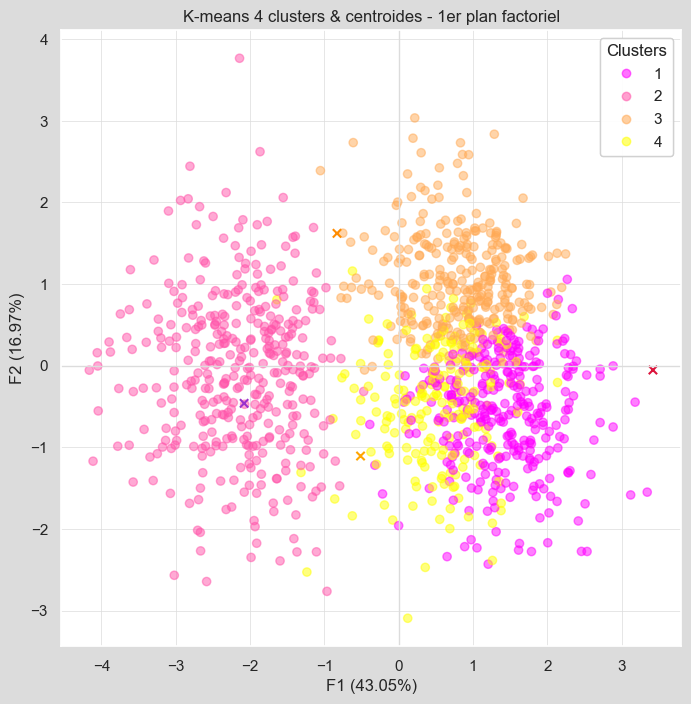

In [32]:
# use initialised scaler
centroids_4_scaled = std_scaler.fit_transform(centroids_4)

# use initialised acp
centroids_4_proj = pca_kmeans.fit_transform(centroids_4_scaled)

# create datafram
centroids_4_proj = pd.DataFrame(centroids_4_proj,
                                columns=["F1", "F2"],
                                index=["cluster_0", "cluster_1", "cluster_2", "cluster_3"])

# plot results
fig, ax = plt.subplots(1, 1)
scatter = ax.scatter(x_proj.iloc[:, 0], x_proj.iloc[:, 1], c=clusters['cluster_km_4'], cmap='spring', alpha=0.5)
ax.scatter(centroids_4_proj.iloc[:, 0], centroids_4_proj.iloc[:, 1],  marker="x",
           c=['darkorchid', 'crimson', 'darkorange', 'orange'])

ax.set_xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0], 2)))
ax.set_ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1], 2)))

# plot thicker abscissa and ordinate lines
plt.axvline(x=0, c='gainsboro', lw=1, linestyle='solid')
plt.axhline(y=0, c='gainsboro', lw=1, linestyle='solid')

# produce a legend with the unique colors from the scatter
legend_1 = ax.legend(*scatter.legend_elements(),
                     loc="upper right", title="Clusters")
ax.add_artist(legend_1)

ax.set_title("K-means 4 clusters & centroides - 1er plan factoriel")
plt.grid(axis='both', color='gainsboro', lw=0.5)
plt.savefig("Kmeans 4 clusters & centroides - 1er plan factoriel.png", bbox_inches='tight')
plt.show()

## 2.5 - K-means performance evaluation sur le training set

In [34]:
clusters.loc[(clusters['is_genuine'] == True), 'labels_true'] = 1
clusters.loc[(clusters['is_genuine'] == False), 'labels_true'] = 0
clusters.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
382         True  1.050853     1.958416     -0.367712   -0.597290  -0.306118   
538         True -0.185700     1.559864     -1.317963   -0.597290  -1.428167   
1493       False -1.064303     0.995247      2.115204    0.618607   0.859087   
1112       False  0.334954     0.829184      1.195606    1.728113   0.513841   
324         True  0.465117     1.294162     -0.980777   -0.445303  -1.126077   

        length  cluster_km_2  cluster_km_3  cluster_km_4  labels_true  
382   0.648529             1             1             3          1.0  
538   0.921625             1             1             4          1.0  
1493 -0.603164             2             2             2          0.0  
1112 -1.229011             2             2             2          0.0  
324   0.716803             1             1             3          1.0

### 2.5.1 - Allocation des etiquettes True / False en fonction des clusters

#### 2.5.1.1 - K-means a 2 clusters

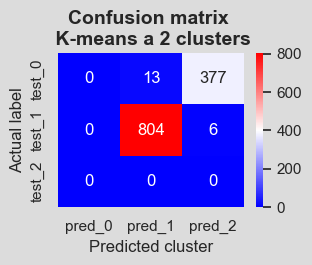

In [35]:
# heatmap of confusion matrix
conf_km2 = confusion(clusters['labels_true'], clusters['cluster_km_2'])
fig, ax = plt.subplots(figsize=(3, 2))
conf_km2 = pd.DataFrame(conf_km2)
sns.heatmap(conf_km2, annot=True, cmap="bwr", fmt='g')
plt.title('Confusion matrix \n K-means a 2 clusters', fontsize=14, fontweight='bold')
plt.ylabel('Actual label', fontsize=12)
plt.xlabel('Predicted cluster', fontsize=12)
plt.savefig("conf_matrix_km2.png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [36]:
# create label data for each cluster based on confusion matrix
val_km2_1 = conf_km2['pred_1'].idxmax()
clust_km2_1 = bool(int(val_km2_1[-1]))
val_km2_2 = conf_km2['pred_2'].idxmax()
clust_km2_2 = bool(int(val_km2_2[-1]))

# automatically reassign cluster numbers to True/False banknotes labels
clusters.loc[clusters['cluster_km_2'] == 1, 'labels_pred_km2'] = clust_km2_1
clusters.loc[clusters['cluster_km_2'] == 2, 'labels_pred_km2'] = clust_km2_2
clusters.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
382         True  1.050853     1.958416     -0.367712   -0.597290  -0.306118   
538         True -0.185700     1.559864     -1.317963   -0.597290  -1.428167   
1493       False -1.064303     0.995247      2.115204    0.618607   0.859087   
1112       False  0.334954     0.829184      1.195606    1.728113   0.513841   
324         True  0.465117     1.294162     -0.980777   -0.445303  -1.126077   

        length  cluster_km_2  cluster_km_3  cluster_km_4  labels_true  \
382   0.648529             1             1             3          1.0   
538   0.921625             1             1             4          1.0   
1493 -0.603164             2             2             2          0.0   
1112 -1.229011             2             2             2          0.0   
324   0.716803             1             1             3          1.0   

     labels_pred_km2  
382             True  
538             True  
1493           False  
1112           False  
324             True

#### 2.5.1.2 - K-means a 3 clusters

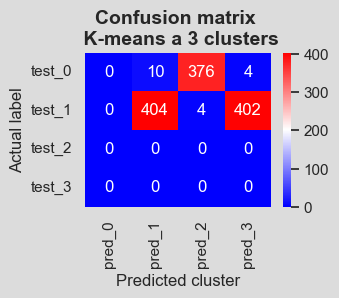

In [37]:
# heatmap of confusion matrix
conf_km3 = confusion(clusters['labels_true'], clusters['cluster_km_3'])
fig, ax = plt.subplots(figsize=(3, 2))
conf_km3 = pd.DataFrame(conf_km3)
sns.heatmap(conf_km3, annot=True, cmap="bwr", fmt='g')
plt.title('Confusion matrix \n K-means a 3 clusters', fontsize=14, fontweight='bold')
plt.ylabel('Actual label', fontsize=12)
plt.xlabel('Predicted cluster', fontsize=12)
plt.savefig("conf_matrix_km3.png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [38]:
# create label data for each cluster based on confusion matrix
val_km3_1 = conf_km3['pred_1'].idxmax()
clust_km3_1 = bool(int(val_km3_1[-1]))
val_km3_2 = conf_km3['pred_2'].idxmax()
clust_km3_2 = bool(int(val_km3_2[-1]))
val_km3_3 = conf_km3['pred_3'].idxmax()
clust_km3_3 = bool(int(val_km3_3[-1]))
# automatically reassign cluster numbers to True/False banknotes labels
clusters.loc[clusters['cluster_km_3'] == 1, 'labels_pred_km3'] = clust_km3_1
clusters.loc[clusters['cluster_km_3'] == 2, 'labels_pred_km3'] = clust_km3_2
clusters.loc[clusters['cluster_km_3'] == 3, 'labels_pred_km3'] = clust_km3_3
clusters.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
382         True  1.050853     1.958416     -0.367712   -0.597290  -0.306118   
538         True -0.185700     1.559864     -1.317963   -0.597290  -1.428167   
1493       False -1.064303     0.995247      2.115204    0.618607   0.859087   
1112       False  0.334954     0.829184      1.195606    1.728113   0.513841   
324         True  0.465117     1.294162     -0.980777   -0.445303  -1.126077   

        length  cluster_km_2  cluster_km_3  cluster_km_4  labels_true  \
382   0.648529             1             1             3          1.0   
538   0.921625             1             1             4          1.0   
1493 -0.603164             2             2             2          0.0   
1112 -1.229011             2             2             2          0.0   
324   0.716803             1             1             3          1.0   

     labels_pred_km2 labels_pred_km3  
382             True            True  
538             True            True  
1493           False           False  
1112           False           False  
324             True            True

####  2.5.1.3 - K-means a 4 clusters

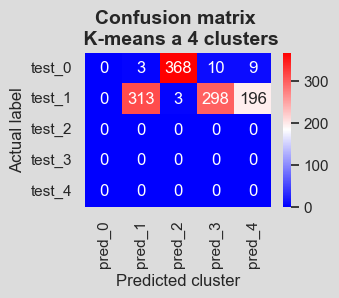

In [39]:
# heatmap of confusion matrix
conf_km4 = confusion(clusters['labels_true'], clusters['cluster_km_4'])
fig, ax = plt.subplots(figsize=(3, 2))
conf_km4 = pd.DataFrame(conf_km4)
sns.heatmap(conf_km4, annot=True, cmap="bwr", fmt='g')
plt.title('Confusion matrix \n K-means a 4 clusters', fontsize=14, fontweight='bold')
plt.ylabel('Actual label', fontsize=12)
plt.xlabel('Predicted cluster', fontsize=12)
plt.savefig("conf_matrix_km4.png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [40]:
# create label data for each cluster based on confusion matrix
val_km4_1 = conf_km4['pred_1'].idxmax()
clust_km4_1 = bool(int(val_km4_1[-1]))
val_km4_2 = conf_km4['pred_2'].idxmax()
clust_km4_2 = bool(int(val_km4_2[-1]))
val_km4_3 = conf_km4['pred_3'].idxmax()
clust_km4_3 = bool(int(val_km4_3[-1]))
val_km4_4 = conf_km4['pred_4'].idxmax()
clust_km4_4 = bool(int(val_km4_4[-1]))

# automatically reassign cluster numbers to True/False banknotes labels
clusters.loc[clusters['cluster_km_4'] == 1, 'labels_pred_km4'] = clust_km4_1
clusters.loc[clusters['cluster_km_4'] == 2, 'labels_pred_km4'] = clust_km4_2
clusters.loc[clusters['cluster_km_4'] == 3, 'labels_pred_km4'] = clust_km4_3
clusters.loc[clusters['cluster_km_4'] == 4, 'labels_pred_km4'] = clust_km4_4
clusters.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
382         True  1.050853     1.958416     -0.367712   -0.597290  -0.306118   
538         True -0.185700     1.559864     -1.317963   -0.597290  -1.428167   
1493       False -1.064303     0.995247      2.115204    0.618607   0.859087   
1112       False  0.334954     0.829184      1.195606    1.728113   0.513841   
324         True  0.465117     1.294162     -0.980777   -0.445303  -1.126077   

        length  cluster_km_2  cluster_km_3  cluster_km_4  labels_true  \
382   0.648529             1             1             3          1.0   
538   0.921625             1             1             4          1.0   
1493 -0.603164             2             2             2          0.0   
1112 -1.229011             2             2             2          0.0   
324   0.716803             1             1             3          1.0   

     labels_pred_km2 labels_pred_km3 labels_pred_km4  
382             True            True            True  
538             True            True            True  
1493           False           False           False  
1112           False           False           False  
324             True            True            True

### 2.5.2 - Rand score & Adjusted Rand Score

##### K-means a 2 clusters

In [41]:
# calculate Rand score = (number of agreeing pairs) / (number of pairs)
print("Rand score:", rand_score(clusters['is_genuine'], clusters['labels_pred_km2']))

# calculate adjusted Rand score. Perfect labeling would be scored 1 and bad labelling or independent labelling is scored
# 0 or negative.
print("Adjusted rand score:", adjusted_rand_score(clusters['is_genuine'], clusters['labels_pred_km2']))

Rand score: 0.9688087294968029
Adjusted rand score: 0.9366134581986845


##### K-means a 3 clusters

In [42]:
# calculate Rand score = (number of agreeing pairs) / (number of pairs)
print("Rand score:", rand_score(clusters['is_genuine'], clusters['labels_pred_km3']))
      
# calculate adjusted Rand score. Perfect labeling would be scored 1 and bad labelling or independent labelling is scored
# 0 or negative.
print("Adjusted rand score:", adjusted_rand_score(clusters['is_genuine'], clusters['labels_pred_km3']))

Rand score: 0.9704253544620517
Adjusted rand score: 0.9398716299079545


##### K-means a 4 clusters

In [43]:
# calculate Rand score = (number of agreeing pairs) / (number of pairs)
print("Rand score:", rand_score(clusters['is_genuine'], clusters['labels_pred_km4']))

# calculate adjusted Rand score. Perfect labeling would be scored 1 and bad labelling or independent labelling is scored
# 0 or negative.
print("Adjusted rand score:",adjusted_rand_score(clusters['is_genuine'], clusters['labels_pred_km4']))

Rand score: 0.9591673616902975
Adjusted rand score: 0.9168673376890834


#### Les meilleurs scores de Rand et Rand ajuste sont atteints avec le K-means a 3 clusters.

### 2.5.3 - Mutual Information-Based Score

##### K-means a 2 clusters

In [44]:
print("MIB:", normalized_mutual_info_score (clusters['is_genuine'], clusters['labels_pred_km2']))

MIB: 0.8740066833488348


##### K-means a 3 clusters

In [45]:
print("MIB:", normalized_mutual_info_score (clusters['is_genuine'], clusters['labels_pred_km3']))

MIB: 0.8813890486809433


 ##### K-means a 4 clusters

In [46]:
print("MIB:", normalized_mutual_info_score (clusters['is_genuine'], clusters['labels_pred_km4']))

MIB: 0.850950708136436


#### Le meilleur MIB score est atteint avec le K-means a 3 clusters.

### 2.5.4 - Adjusted Mutual Information

##### K-means a 2 clusters

In [47]:
print("Adjusted MIB:", adjusted_mutual_info_score(clusters['is_genuine'], clusters['labels_pred_km2']))

Adjusted MIB: 0.8739229387961293


 ##### K-means a 3 clusters

In [48]:
print("Adjusted MIB:", adjusted_mutual_info_score(clusters['is_genuine'], clusters['labels_pred_km3']))

Adjusted MIB: 0.8813100902636228


 ##### K-means a 4 clusters

In [49]:
print("Adjusted MIB:", adjusted_mutual_info_score(clusters['is_genuine'], clusters['labels_pred_km4']))

Adjusted MIB: 0.8508510151953673


#### La meilleures Adjusted Mutual Information est atteinte avec le K-means a 3 clusters.

### 2.5.5 - Fowlkes-Mallows Score

The Fowlkes-Mallows function measures the similarity of two clustering of a set of points. It may be defined as the geometric mean of the pairwise precision and recall.

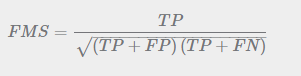

Here, TP = True Positive − number of pair of points belonging to the same clusters in true as well as predicted labels both.

FP = False Positive − number of pair of points belonging to the same clusters in true labels but not in the predicted labels.

FN = False Negative − number of pair of points belonging to the same clusters in the predicted labels but not in the true labels.

Source: https://www.tutorialspoint.com/scikit_learn/scikit_learn_clustering_performance_evaluation.htm

##### K-means a 2 clusters

In [50]:
print("FM score:", fowlkes_mallows_score(clusters['is_genuine'], clusters['labels_pred_km2']))

FM score: 0.9723037747907189


 ##### K-means a 3 clusters

In [51]:
print("FM score:", fowlkes_mallows_score(clusters['is_genuine'], clusters['labels_pred_km3']))

FM score: 0.9737890998256999


 ##### K-means a 4 clusters

In [52]:
print("FM score:", fowlkes_mallows_score(clusters['is_genuine'], clusters['labels_pred_km4']))

FM score: 0.9640225753962801


#### Le meilleur score de Fowlkes-Mallows est atteint avec le K-means a 3 clusters.

### 2.5.6 - Matrice de confusion

##### K-means a 2 clusters

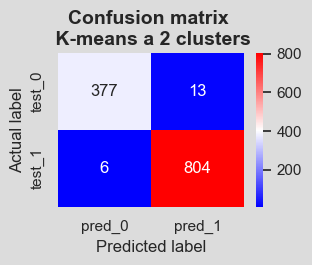

In [53]:
# heatmap of confusion matrix
conf_km2_2 = confusion(clusters['is_genuine'].astype(bool), clusters['labels_pred_km2'].astype(bool))
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(pd.DataFrame(conf_km2_2), annot=True, cmap="bwr", fmt='g')
plt.title('Confusion matrix \n K-means a 2 clusters', fontsize=14, fontweight='bold')
plt.ylabel('Actual label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.savefig("conf_matrix_km2_2.png", bbox_inches='tight', pad_inches=0.5)
plt.show()

Sur 810 vrais billets, 6 sont predits faux (0.7% de faux negatifs). Sur 390 faux billets, 13 sont predits vrais (3.33% de faux positifs).

##### K-means a 3 clusters

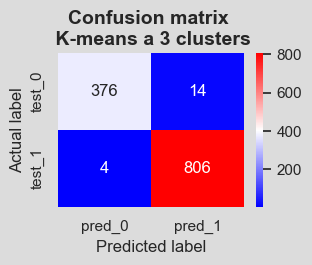

In [54]:
# heatmap of confusion matrix
conf_km3_2 = confusion(clusters['is_genuine'].astype(bool), clusters['labels_pred_km3'].astype(bool))
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(pd.DataFrame(conf_km3_2), annot=True, cmap="bwr", fmt='g')
plt.title('Confusion matrix \n K-means a 3 clusters', fontsize=14, fontweight='bold')
plt.ylabel('Actual label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.savefig("conf_matrix_km3_2.png", bbox_inches='tight', pad_inches=0.5)
plt.show()

Sur 810 vrais billets, 3 sont predits faux (0.37% de faux negatifs). Sur 390 faux billets, 14 sont predits vrais (3.58% de faux positifs).

##### K-means a 4 clusters

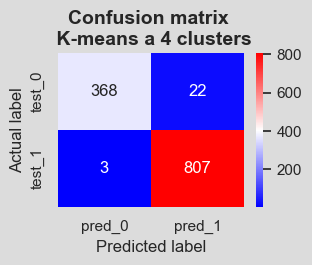

In [55]:
# heatmap of confusion matrix
conf_km4_2 = confusion(clusters['is_genuine'].astype(bool), clusters['labels_pred_km4'].astype(bool))
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(pd.DataFrame(conf_km4_2), annot=True, cmap="bwr", fmt='g')
plt.title('Confusion matrix \n K-means a 4 clusters', fontsize=14, fontweight='bold')
plt.ylabel('Actual label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.savefig("conf_matrix_km4_2.png", bbox_inches='tight', pad_inches=0.5)
plt.show()

Sur 810 vrais billets, 3 sont predits faux (0.37% de faux negatifs). Sur 390 faux billets, 22 sont predits vrais (5.64% de faux positifs).

#### Le K-means a 2 clusters minimise les faux positifs (13/390), les K-means a 3 et 4 clusters minimisent les faux negatifs (3/810)

### Tous les scores verifies ici concluent a la superiorite de la modelisation par un K-means a 3 clusters par rapport a 2 ou 4 clusters, a l'exception de la matrice de confusion qui rapporte un taux de faux positifs tres legerement superieur pour le K-means a 3 clusters par rapport a 2 clusters (14/390 contre 13/390).
### On choisira donc le K-means a 3 clusters, qui permet d'atteindre une meilleure performance sur les faux positifs garantissant le taux de faux negatifs le plus bas.

In [1]:
## 2.6 - Projection des 1500 billets sur le 1er plan factoriel

In [ ]:
# Import data & split file
data = pd.read_csv('billets_final.csv', encoding='latin_1')
x = data[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']].values

# center & reduce data
std_scaler = StandardScaler()
std_scaler.fit(x)
x_scaled = std_scaler.transform(x)

# run K-means
kmeans_2 = KMeans(n_clusters=2, init='k-means++', copy_x=True, algorithm='elkan', n_init=30, max_iter=300, verbose=0,
                  random_state=42, tol=0.00001)
kmeans_2.fit(x_scaled)

# run PCA
pca_kmeans = PCA(n_components=2, random_state=42)
pca_kmeans.fit(x_scaled)
x_proj = pca_kmeans.transform(x_scaled)

# plot clusters in 1st factorial plane
x_proj = pd.DataFrame(x_proj, columns=["PC1", "PC2"])
fig, ax = plt.subplots(1, 1)
scatter1 = sns.scatterplot(x=x_proj.iloc[:, 0], y=x_proj.iloc[:, 1], hue=data['is_genuine'],
                           palette=['palegreen', 'coral'], hue_order=[True, False], alpha=0.5)
ax.set_xlabel('F{} ({}%)'.format(1, round(100*pca_kmeans.explained_variance_ratio_[0], 2)))
ax.set_ylabel('F{} ({}%)'.format(2, round(100*pca_kmeans.explained_variance_ratio_[1], 2)))

# plot thicker abscissa and ordinate lines
plt.axvline(x=0, c='gainsboro', lw=1, linestyle='solid')
plt.axhline(y=0, c='gainsboro', lw=1, linestyle='solid')
plt.legend(title='')
ax.set_title("1500 billets - 1er plan factoriel")
plt.grid(axis='both', color='gainsboro', lw=0.5)
plt.savefig("1500_billets.png", bbox_inches='tight')
plt.show()

## 2.6 - Evaluation de la performance du K-means final sur le testing set

In [56]:
# scale data
x_test_scaled = std_scaler.transform(x_test)

# create dataframe to store results
clusters_test = pd.DataFrame(y_test)
clusters_test[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
               'length']] = x_test_scaled
clusters_test.loc[(clusters_test['is_genuine'] == True), 'labels_true'] = 1
clusters_test.loc[(clusters_test['is_genuine'] == False), 'labels_true'] = 0

# run K-means
kmeans_3.fit_predict(x_test_scaled)
labels_final_test = kmeans_3.labels_

# add cluster number to each country in clusters dataframe
clusters_test['cluster_pred_test'] = (labels_final_test + 1)
clusters_test.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
1116       False  0.988419    -0.432698      0.613462    0.768146   1.158762   
1368       False -1.010969     0.970286      1.412188    1.769038   0.382015   
422         True -1.404291    -1.668661     -0.891828   -0.672532  -0.826257   
413         True  1.119526    -1.234404     -1.291191   -0.489735   0.036795   
451         True  0.693427    -0.800146     -1.168310   -0.627037  -1.603003   

        length  labels_true  cluster_pred_test  
1116 -1.614440          0.0                  1  
1368 -0.433841          0.0                  1  
422   0.093416          1.0                  3  
413   0.311197          1.0                  2  
451   0.402894          1.0                  3

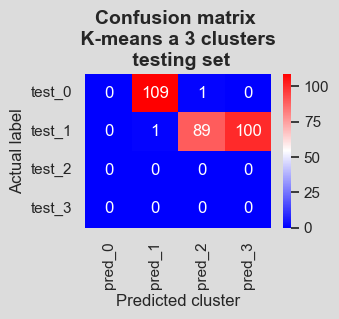

In [57]:
# heatmap of confusion matrix
conf_kmtest = confusion(clusters_test['labels_true'], clusters_test['cluster_pred_test'])
fig, ax = plt.subplots(figsize=(3, 2))
conf_kmtest = pd.DataFrame(conf_kmtest)
sns.heatmap(conf_kmtest, annot=True, cmap="bwr", fmt='g')
plt.title('Confusion matrix \n K-means a 3 clusters \n testing set', fontsize=14, fontweight='bold')
plt.ylabel('Actual label', fontsize=12)
plt.xlabel('Predicted cluster', fontsize=12)
plt.savefig("conf_matrix_kmtest.png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [58]:
# create label data for each cluster based on confusion matrix
val_kmtest_1 = conf_kmtest['pred_1'].idxmax()
clust_kmtest_1 = bool(int(val_kmtest_1[-1]))
val_kmtest_2 = conf_kmtest['pred_2'].idxmax()
clust_kmtest_2 = bool(int(val_kmtest_2[-1]))
val_kmtest_3 = conf_kmtest['pred_3'].idxmax()
clust_kmtest_3 = bool(int(val_kmtest_3[-1]))

# automatically reassign cluster numbers to True/False banknotes labels
clusters_test.loc[clusters_test['cluster_pred_test'] == 1, 'labels_pred_test'] = clust_kmtest_1
clusters_test.loc[clusters_test['cluster_pred_test'] == 2, 'labels_pred_test'] = clust_kmtest_2
clusters_test.loc[clusters_test['cluster_pred_test'] == 3, 'labels_pred_test'] = clust_kmtest_3
clusters_test.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
1116       False  0.988419    -0.432698      0.613462    0.768146   1.158762   
1368       False -1.010969     0.970286      1.412188    1.769038   0.382015   
422         True -1.404291    -1.668661     -0.891828   -0.672532  -0.826257   
413         True  1.119526    -1.234404     -1.291191   -0.489735   0.036795   
451         True  0.693427    -0.800146     -1.168310   -0.627037  -1.603003   

        length  labels_true  cluster_pred_test labels_pred_test  
1116 -1.614440          0.0                  1            False  
1368 -0.433841          0.0                  1            False  
422   0.093416          1.0                  3             True  
413   0.311197          1.0                  2             True  
451   0.402894          1.0                  3             True

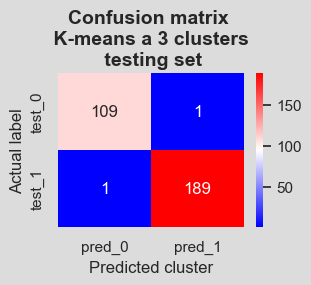

In [59]:
# heatmap of confusion matrix
conf_kmtest_2 = confusion(clusters_test['labels_true'].astype(bool), clusters_test['labels_pred_test'].astype(bool))
fig, ax = plt.subplots(figsize=(3, 2))
conf_kmtest_2 = pd.DataFrame(conf_kmtest_2)
sns.heatmap(conf_kmtest_2, annot=True, cmap="bwr", fmt='g')
plt.title('Confusion matrix \n K-means a 3 clusters \n testing set', fontsize=14, fontweight='bold')
plt.ylabel('Actual label', fontsize=12)
plt.xlabel('Predicted cluster', fontsize=12)
plt.savefig("conf_matrix_kmtest.png", bbox_inches='tight', pad_inches=0.5)
plt.show()

### Indicateurs de performance

In [60]:
# calculate Rand score = (number of agreeing pairs) / (number of pairs)
print("Rand score:", rand_score(clusters_test['is_genuine'], clusters_test['labels_pred_test']))
      
# calculate adjusted Rand score. Perfect labeling would be scored 1 and bad labelling or independent labelling is scored
# 0 or negative.
print("Adjusted rand score:", adjusted_rand_score(clusters_test['is_genuine'], clusters_test['labels_pred_test']))

Rand score: 0.9867112597547381
Adjusted rand score: 0.9732990380677448


In [61]:
print("MIB:", normalized_mutual_info_score (clusters_test['is_genuine'], clusters_test['labels_pred_test']))

MIB: 0.9394345891859972


In [62]:
print("Adjusted MIB:", adjusted_mutual_info_score(clusters_test['is_genuine'], clusters_test['labels_pred_test']))

Adjusted MIB: 0.9392796473703022


In [63]:
print("FM score:", fowlkes_mallows_score(clusters_test['is_genuine'], clusters_test['labels_pred_test']))

FM score: 0.9875574112734864


# 3 - Prediction sur l'echantillon de production

In [64]:
# Import data
data_prod = pd.read_csv('billets_production.csv', encoding='latin_1')

# check for missing values
if (data_prod.loc[data_prod.isna().any(axis=1) == True].shape[0]) != 0:
    print("!!! Valeurs manquantes !!!")
else:
    print ("Pas de valeurs manquantes.")
# check for missing data
if (data_prod.loc[data_prod.isnull().any(axis=1) == True].shape[0]) != 0:
    print("!!! Valeurs nulles !!! ")
else:
    print ("Pas de valeurs nulles.")
# check for duplicates
if (data_prod.loc[data_prod.duplicated() == True].shape[0]) != 0:
    print("!!! Doublons dans la table !!!")
else:
    print ("Pas de doublons dans la table.")

Pas de valeurs manquantes.
Pas de valeurs nulles.
Pas de doublons dans la table.


In [65]:
# split file
x_prod_1 = data_prod[['diagonal', 'height_left', 'height_right', 'margin_low',
                      'margin_up', 'length']].values

# scale data
x_prod_1_scaled = std_scaler.transform(x_prod_1)

# run K-means
kmeans_3.fit_predict(x_prod_1_scaled)
labels_final = kmeans_3.labels_

# add cluster number to each country in clusters dataframe
data_prod['cluster_pred_prod'] = (labels_final + 1)


# automatically reassign cluster numbers to True/False banknotes labels
data_prod.loc[data_prod['cluster_pred_prod'] == 1, 'labels_pred_prod'] = clust_km3_1
data_prod.loc[data_prod['cluster_pred_prod'] == 2, 'labels_pred_prod'] = clust_km3_2
data_prod.loc[data_prod['cluster_pred_prod'] == 3, 'labels_pred_prod'] = clust_km3_3
data_prod

diagonal  height_left  height_right  margin_low  margin_up  length   id  \
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1   
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2   
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3   
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4   
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5   

   cluster_pred_prod labels_pred_prod  
0                  1             True  
1                  1             True  
2                  1             True  
3                  2            False  
4                  3             True

In [66]:
# print results
print("Resultats:\n")
for k, l in zip(data_prod["labels_pred_prod"], data_prod["id"]):
    if k == 1:
        print(f"Le billet ref. {l} est un vrai billet.")
    else:
        print(f"Le billet ref. {l} est un faux billet.")

Resultats:

Le billet ref. A_1 est un vrai billet.
Le billet ref. A_2 est un vrai billet.
Le billet ref. A_3 est un vrai billet.
Le billet ref. A_4 est un faux billet.
Le billet ref. A_5 est un vrai billet.
